# Selection of reservoirs - EFAS
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 03-10-2024<br>

**Introduction:**<br>
In this notebook I will load different reservoir datasets (EFAS, [GLWD](https://www.sciencedirect.com/science/article/pii/S0022169404001404), [GRanD](https://esajournals.onlinelibrary.wiley.com/doi/full/10.1890/100125), ICOLD and Hydrolakes), compare them, and select reservoirs from the GRanD dataset that aren't currently included in EFAS.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopandas as gpd
import glob
import cartopy.feature as cf
import cartopy.crs as ccrs
from tqdm.notebook import tqdm
from shapely.geometry import Point
from pathlib import Path

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from lisfloodreservoirs.utils.utils import filter_domain, filter_reservoirs, find_connections, remove_duplicates
from lisfloodreservoirs.utils.plots import plot_reservoir_map

## Configuration

In [2]:
# paths
PATH_DATASETS = Path('Z:/nahaUsers/casadje/datasets/')
PATH_EFAS = Path('Z:/nahaUsers/casadje/EFASv5')
PATH_OUT = PATH_DATASETS / 'reservoirs' / 'EFASv6' #Path('../results/reservoirs/selection/EFAS/')
PATH_OUT.mkdir(parents=True, exist_ok=True)

# minimum storage capacity included in EFAS
MIN_VOLUME = 10 # hm³
MIN_AREA = 50 # km²
MIN_DOR = 0.08 #

## EFAS

In [3]:
# load the upstream area map
uparea = rxr.open_rasterio(PATH_EFAS / 'static_maps' / 'upArea_European_01min.nc').squeeze(dim='band')
uparea = uparea.where(uparea != -999999, np.nan)

# load the domain
domain = rxr.open_rasterio(PATH_EFAS / 'static_maps' / 'domain_area_European_01min.nc').squeeze(dim='band')
lon_min, lat_min, lon_max, lat_max = np.round(domain.rio.bounds(), 6)
efas_cellsize = np.mean(np.diff(domain.x)) # degrees

I will load two products from EFAS: a raster with the location and ID of the reservoirs, and a table with the metadata. The raster is only loaded to check that the coordinates in the metadata correspond to the corrected coordinates used in LISFLOOD. To the metadata I will add as new attributes the reservoir tables used in the LISFLOOD simulation, which contain the reservoir parameters: total storage, filling and outflow at different reservoir levels, and the catchment area extracted from the _upArea_ static map.

### Raster

In [4]:
efas_raster = xr.open_dataset(PATH_EFAS / 'static_maps' / 'res_European_01min.nc')['res']

# remove rows/columns with all NaN
aux = efas_raster.where(~efas_raster.isnull(), drop=True)
# extract an array of reservoir ID
ids = np.unique(aux)
ids = [int(ID) for ID in ids[~np.isnan(ids)]]

# extract coordinates of each reservoir
efas_coords = pd.DataFrame(index=ids, columns=['lon', 'lat'], dtype=float)
efas_area = pd.Series(index=ids, dtype=float)
for ID in tqdm(efas_coords.index):
    cell = efas_raster.where(efas_raster == ID, drop=True)
    lon, lat = cell.lon.item(), cell.lat.item()
    efas_coords.loc[int(ID)] = lon, lat
    efas_area.loc[int(ID)] = uparea.sel(x=lon, y=lat, method='nearest', tolerance=1e-4).item()
efas_coords = efas_coords.round(6)

# convert area to km2
efas_area *= 1e-6

del aux

  0%|          | 0/1420 [00:00<?, ?it/s]

### Metadata

In [5]:
# load efas metadata
efas = pd.read_csv(PATH_EFAS / 'tables' / 'EFAS_HRES_Reservoirs_metadata.csv')
efas.ResID = efas.ResID.astype(int)
efas.set_index('ResID', inplace=True)
efas = gpd.GeoDataFrame(efas,
                        geometry=[Point(xy) for xy in zip(efas.LisfloodX, efas.LisfloodY)],
                        crs=4326)

# simplify lake name
# efas.LAKE_NAME = efas.LAKE_NAME.str.lower()
# efas.LAKE_NAME = efas.LAKE_NAME.str.replace(r'(lake|reservoir)', '', case=False)
# efas.LAKE_NAME = efas.LAKE_NAME.str.strip()
efas.DAM_NAME = efas.DAM_NAME.str.lower()
# efas.RIVER = efas.RIVER.str.lower()

# add catchment area (km2)
efas['area'] = efas_area

# add attributes from the tables used in LISFLOOD
prefix = 'r'
for file in (PATH_EFAS / 'tables').glob(f'{prefix}*.txt'):
    var = file.stem.removeprefix(prefix)
    try:
        df = pd.read_csv(file, sep=' ', header=None)
        df.dropna(axis=1, how='all', inplace=True)
        df.columns = ['ResID', var]
        df.set_index('ResID', inplace=True, drop=True)
        efas[var] = df
    except:
        print(file)
        continue
# convert storage from m3 to hm³
efas.tstor /= 1e6 

### Comparison

In [6]:
print('no. reservoirs in the metadata:\t\t{0}'.format(efas.shape[0]))
print('no. reservoirs in the raster:\t\t{0}'.format(efas_coords.shape[0]))
print('reservoirs missing in the metadata:\t{0}'.format(efas_coords.index.difference(efas.index).to_list()))
print('reservoirs missing in the raster:\t{0}'.format(efas.index.difference(efas_coords.index).to_list()))

no. reservoirs in the metadata:		1423
no. reservoirs in the raster:		1420
reservoirs missing in the metadata:	[]
reservoirs missing in the raster:	[3132, 4043, 4048]


In [7]:
mask_efas = filter_reservoirs(efas['area'], efas['tstor'], catch_thr=MIN_AREA, vol_thr=MIN_VOLUME)

1200 out of 1423 reservoirs exceed the minimum catchment area of 50 km2 (3 missing values)
1365 out of 1423 reservoirs exceed the minimum reservoir volume of 10 hm3 (0 missing values)
1157 out of 1423 reservoirs exceed the minimum catchment area (50 km2) and the minimum reservoir volume (10 hm3)


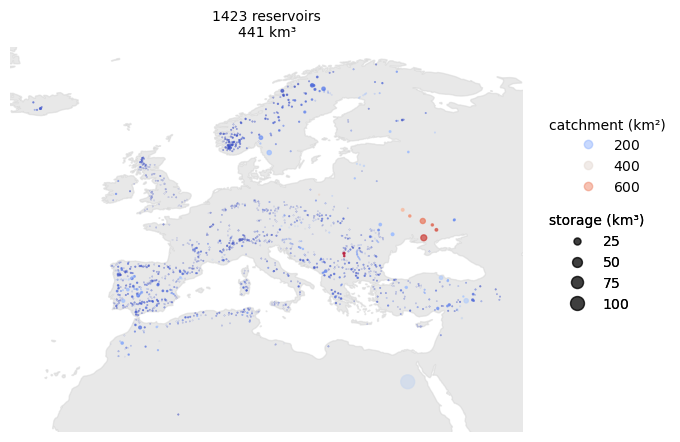

In [8]:
# plot reservoir map
plot_reservoir_map(efas.geometry, efas.tstor, efas['area'], save=PATH_OUT / 'EFAS5' / 'efasv5_reservoirs.jpg')

***Figure 1**. Reservoirs included in EFAS. The size of the dots represents the storage capacity.*

## GRanD

GRanD includes both a point shapefile of dams and a polygon shapefile with reservoirs. The amount of reservoirs is slightly smaller than that of dams, but the attributes are the same, so I will use only the dams for the analysis.

### Import

  0%|          | 0/1609 [00:00<?, ?it/s]

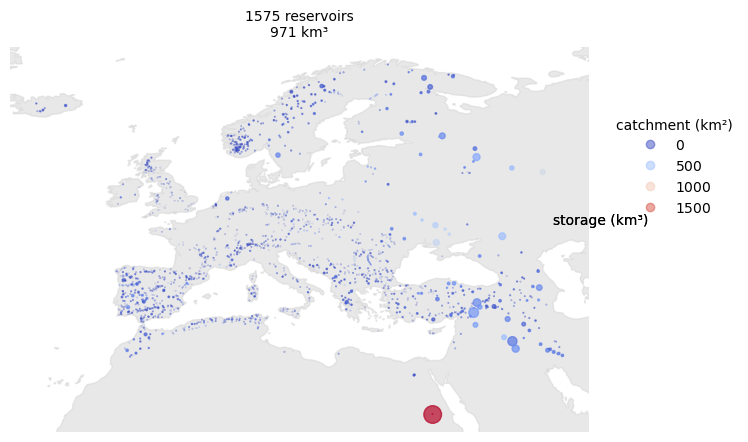

In [9]:
# import data set
PATH_GRAND = PATH_DATASETS / 'reservoirs' / 'GRanD' / 'v1_3'
grand = gpd.read_file(PATH_GRAND / 'grand_dams_v1_3.shp')
grand.set_index('GRAND_ID', drop=True, inplace=True)
grand = grand.replace(-99, np.nan)

# filter points in the EFAS domain
grand = filter_domain(grand, domain)

# convert in NaN suspicious values of degree of regulation
grand.DOR_PC = grand.DOR_PC.replace(10000, np.nan)
# compute degree of regulation as in Shrestha et al. (2024)
grand['DOR'] = grand.CAP_MCM / (grand.DIS_AVG_LS * 3600 * 24 * 365 * 1e-9)

# tune lake names in GRanD
grand.RES_NAME = grand.RES_NAME.str.lower()
grand.RES_NAME = grand.RES_NAME.str.replace(r'(lake|reservoir)', '', case=False)
grand.RES_NAME = grand.RES_NAME.str.strip()
grand.DAM_NAME = grand.DAM_NAME.str.lower()
grand.RIVER = grand.RIVER.str.lower()

# plot reservoirs
plot_reservoir_map(grand.geometry, grand.CAP_MCM, grand.CATCH_SKM, save=PATH_OUT / 'GRanD' / 'grand_reservoirs.jpg')

***Figure 2**. Dams included in the GRanD data set. The size of the dots represents the storage capacity of the reservoir and the colour the degree of regulation (red for stronger regulation).*

In [10]:
# apply selection to reservoir polygons
grand_res = gpd.read_file(PATH_GRAND / 'GRanD_reservoirs_v1_3.shp')
grand_res.set_index('GRAND_ID', drop=True, inplace=True)
grand_res = grand_res.loc[grand.index.intersection(grand_res.index)]
grand_res.shape

(1543, 58)

In [188]:
# export selection of polygons
grand_res.to_file(PATH_OUT / 'GRanD' / 'grand_reservoirs.shp')

### Selection rules

In [11]:
# filter reservoirs
mask_grand = filter_reservoirs(grand.CATCH_SKM, grand.CAP_MCM, catch_thr=MIN_AREA, vol_thr=MIN_VOLUME)

# add two fields:
# 'selected' is a boolean field that identifies reservoirs that comply with the storage and catchment rules
# 'as_lake' is a boolean field that identifies reservoirs that should be modelled as lakes due to small regulation
grand[['selected', 'as_lake']] = 0
grand.loc[mask_grand, 'selected'] = 1
grand.loc[grand.DOR < MIN_DOR, 'as_lake'] = 1

1324 out of 1575 reservoirs exceed the minimum catchment area of 50 km2 (0 missing values)
1522 out of 1575 reservoirs exceed the minimum reservoir volume of 10 hm3 (2 missing values)
1285 out of 1575 reservoirs exceed the minimum catchment area (50 km2) and the minimum reservoir volume (10 hm3)


In [190]:
# export
grand.to_file(PATH_OUT / 'GRanD' / 'grand_dams.shp')

### Find connections

#### GRanD to EFAS 

In [12]:
# find GRanD ID
map_efas_grand = find_connections(efas, grand, max_distance=5*efas_cellsize)
print('{0} out of {1} EFAS reservoirs were located in GRanD'.format(len(map_efas_grand), efas.shape[0]))
efas['GRAND_ID'] = [map_efas_grand[ID] if ID in map_efas_grand else -9999 for ID in efas.index]

# assign other GRanD attributes
map_fields = {
    'GRAND_RES': 'RES_NAME',
    'GRAND_DAM': 'DAM_NAME',
    'GRAND_RIV': 'RIVER',
    'CATCH_SKM': 'CATCH_SKM',
    'CAP_MCM': 'CAP_MCM',
    'DOR': 'DOR'
}
for col_efas, col_grand in map_fields.items():
    efas.loc[map_efas_grand.keys(), col_efas] = grand.loc[map_efas_grand.values(), col_grand].values

  0%|          | 0/1423 [00:00<?, ?it/s]

1365 out of 1423 EFAS reservoirs were located in GRanD


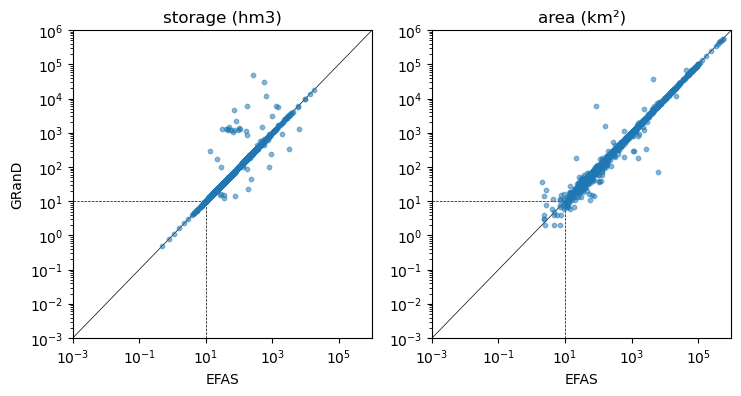

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(8.5, 4))
vmin, vmax = 1e-3, 1e6

ax[0].plot([vmin, 1e6], [vmin, 1e6], c='k', lw=.5, zorder=0)
ax[0].vlines(MIN_VOLUME, vmin, MIN_VOLUME, color='k', ls='--', lw=.5, zorder=0)
ax[0].hlines(MIN_VOLUME, vmin, MIN_VOLUME, color='k', ls='--', lw=.5, zorder=0)
ax[0].scatter(efas.tstor, efas.CAP_MCM, s=10, alpha=.5)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set(
    title='storage (hm3)',
    xlim=(vmin, vmax),
    xlabel='EFAS',
    ylim=(vmin, vmax),
    ylabel='GRanD'
);

ax[1].plot([vmin, 1e6], [vmin, 1e6], c='k', lw=.5, zorder=0)
ax[1].vlines(MIN_VOLUME, vmin, MIN_VOLUME, color='k', ls='--', lw=.5, zorder=0)
ax[1].hlines(MIN_VOLUME, vmin, MIN_VOLUME, color='k', ls='--', lw=.5, zorder=0)
ax[1].scatter(efas['area'], efas.CATCH_SKM, s=10, alpha=.5)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[1].set(
    title='area (km²)',
    xlim=(vmin, vmax),
    xlabel='EFAS',
    ylim=(vmin, vmax),
    # ylabel='GRanD'
);

### To be added

In [14]:
# select reservoirs from GRanD to be added
grand_new = grand[grand.selected == 1]
grand_new = grand_new.loc[grand_new.index.difference(efas.GRAND_ID)]

#### Remove reservoirs
##### Data quality

In [15]:
# keep only reservoirs with a fair or higher data quality
grand_mask_quality = grand_new.QUALITY.isin(['3: Fair', '2: Good', '1: Verified'])
grand_new = grand_new[grand_mask_quality]

print('GRanD not in EFAS (V >= {0} hm³):\t{1} reservoirs\t\t{2:.0f} hm³'.format(
    MIN_VOLUME,
    grand_new.shape[0],
    grand_new.CAP_MCM.sum()
))

grand_new.QUALITY.value_counts()

GRanD not in EFAS (V >= 10 hm³):	183 reservoirs		527145 hm³


2: Good        91
3: Fair        90
1: Verified     2
Name: QUALITY, dtype: int64

##### Timeline

In [16]:
# remove non-existing reservoirs
grand_mask_timeline = grand_new.TIMELINE.isin(['Replaced', 'Planned', 'Destroyed', 'Under construction', 'Subsumed'])
grand_new = grand_new[~grand_mask_timeline]

print('GRanD not in EFAS (V >= {0} hm³):\t{1} reservoirs\t\t{2:.0f} hm³'.format(
    MIN_VOLUME,
    grand_new.shape[0],
    grand_new.CAP_MCM.sum()
))

grand_new.TIMELINE.value_counts()

GRanD not in EFAS (V >= 10 hm³):	182 reservoirs		527117 hm³


Modified    1
Name: TIMELINE, dtype: int64

In [194]:
# export
grand_new.to_file(PATH_OUT / 'GRanD' / 'grand_to_add.shp')

## GLWD

The GLWD level 1 product includes polygons of the water bodies (either lakes or reservoirs), from which I will keep only reservoirs. 

### Import

  0%|          | 0/102 [00:00<?, ?it/s]

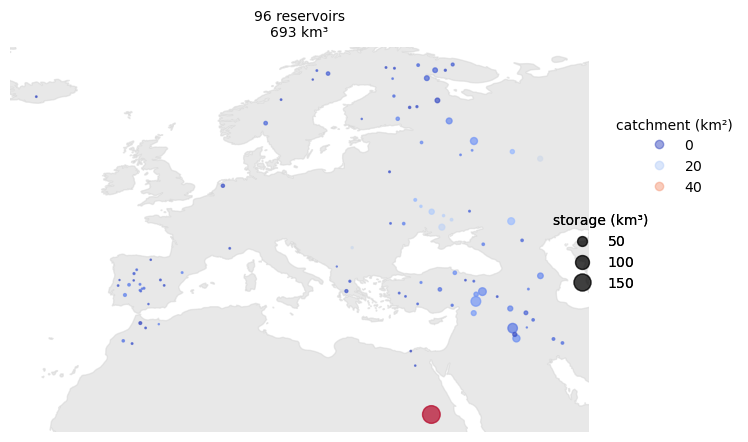

In [17]:
# import data set
path_glwd = PATH_DATASETS / 'lakes' / 'GLWD' / 'level1'
glwd = gpd.read_file(path_glwd / 'glwd_1.shp')
glwd.set_index('GLWD_ID', drop=True, inplace=True)
glwd.crs = 'EPSG:4326'

# keep only reservoirs
glwd = glwd.loc[glwd.TYPE == 'Reservoir']

# convert reservoir volume to hm³ (million cubic meters)
glwd['VOLUME_MCM'] = glwd.VOLUME_CKM * 1000
glwd.drop('VOLUME_CKM', axis=1, inplace=True)

# remove empty fields
glwd.dropna(axis=1, how='all', inplace=True)

# convert polygon GeoDataFrame to point GeoDataFrame
glwd = gpd.GeoDataFrame(glwd, geometry=[Point(xy) for xy in zip(glwd.LONG_DEG, glwd.LAT_DEG)])
glwd .crs = 'EPSG:4326'

# # tune lake names in GLWD
glwd.LAKE_NAME = glwd.LAKE_NAME.str.lower()
glwd.LAKE_NAME = glwd.LAKE_NAME.str.replace(r'(lake|reservoir)', '', case=False)
glwd.LAKE_NAME = glwd.LAKE_NAME.str.strip()

# keep points inside the EFAS domain
glwd = filter_domain(glwd, domain)

# plot
plot_reservoir_map(glwd.geometry, glwd.VOLUME_MCM, glwd.CATCH_TSKM, save=PATH_OUT / 'GLWD' / 'glwd_reservoirs.jpg')

***Figure 3**. Reservoirs in the GLWD data set. The dot size indicates the storage capacity.*

### Selection rules

In [18]:
mask_glwd = filter_reservoirs(glwd.CATCH_TSKM, glwd.VOLUME_MCM, vol_thr=MIN_VOLUME, catch_thr=MIN_AREA)
glwd['selected'] = 0
glwd.loc[mask_glwd, 'selected'] = 1

27 out of 96 reservoirs exceed the minimum catchment area of 50 km2 (0 missing values)
96 out of 96 reservoirs exceed the minimum reservoir volume of 10 hm3 (0 missing values)
27 out of 96 reservoirs exceed the minimum catchment area (50 km2) and the minimum reservoir volume (10 hm3)


In [196]:
# export
glwd.to_file(PATH_OUT / 'GLWD' / 'glwd.shp')

27 out of 96 reservoirs exceed the minimum catchment area of 50 km2 (0 missing values)
96 out of 96 reservoirs exceed the minimum reservoir volume of 10 hm3 (0 missing values)
27 out of 96 reservoirs exceed the minimum catchment area (50 km2) and the minimum reservoir volume (10 hm3)


## ICOLD

### Import

  0%|          | 0/8083 [00:00<?, ?it/s]

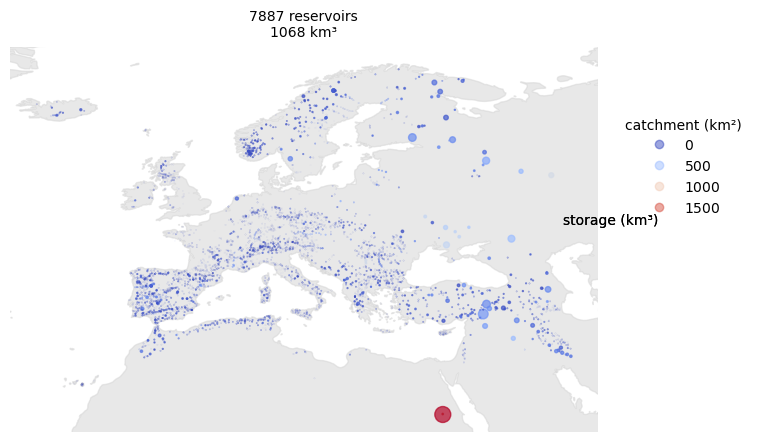

In [19]:
# import data set
path_ICOLD = PATH_DATASETS / 'reservoirs' / 'ICOLD' / '2023'
icold = gpd.read_file(path_ICOLD / 'ICOLD_global.shp')
remove_duplicates(icold, duplicates_col='Int_Code', select_col='Year', inplace=False)
icold.set_index('Int_Code', drop=True, inplace=True)

# keep points inside the EFAS domain
icold = filter_domain(icold, domain)

# convert volume into hm3
icold.Res_Vol *= 1e-3

# plot reservoir
plot_reservoir_map(icold.geometry, icold.Res_Vol, icold.Catch_Area, save=PATH_OUT / 'ICOLD' / 'icold_reservoirs.jpg')

### Selection rules

In [20]:
# apply selection rultes
mask_icold = filter_reservoirs(icold.Catch_Area, icold.Res_Vol, catch_thr=MIN_AREA, vol_thr=MIN_VOLUME)
icold['selected'] = 0
icold.loc[mask_icold, 'selected'] = 1

5835 out of 7887 reservoirs exceed the minimum catchment area of 50 km2 (2966 missing values)
2731 out of 7887 reservoirs exceed the minimum reservoir volume of 10 hm3 (145 missing values)
2380 out of 7887 reservoirs exceed the minimum catchment area (50 km2) and the minimum reservoir volume (10 hm3)


In [198]:
# export
icold.to_file(PATH_OUT / 'ICOLD' / 'icold.shp')

### Find connections

#### ICOLD to EFAS

In [21]:
# find EFAS ID
map_efas_icold= find_connections(efas, icold, max_distance=5 * efas_cellsize)
print('{0} out of {1} EFAS reservoirs were located in ICOLD'.format(len(map_efas_icold), efas.shape[0]))
efas['ICOLD_ID'] = [map_efas_icold[ID] if ID in map_efas_icold else -9999 for ID in efas.index]

# assign ICOLD attributes
map_fields = {
    'ICOLD_RES': 'Res_Name',
    'ICOLD_DAM': 'Dam_Name',
    'ICOLD_RIV': 'River',
    'ICOLD_AREA': 'Catch_Area',
    'ICOLD_VOL': 'Res_Vol',
}
for col_efas, col_icold in map_fields.items():
    efas.loc[map_efas_icold.keys(), col_efas] = icold.loc[map_efas_icold.values(), col_icold].values

  0%|          | 0/1423 [00:00<?, ?it/s]

1380 out of 1423 EFAS reservoirs were located in ICOLD


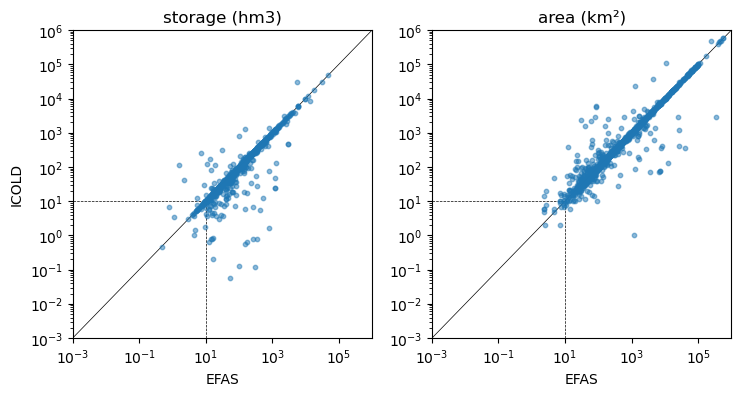

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(8.5, 4))
vmin, vmax = 1e-3, 1e6

ax[0].plot([vmin, 1e6], [vmin, 1e6], c='k', lw=.5, zorder=0)
ax[0].vlines(MIN_VOLUME, vmin, MIN_VOLUME, color='k', ls='--', lw=.5, zorder=0)
ax[0].hlines(MIN_VOLUME, vmin, MIN_VOLUME, color='k', ls='--', lw=.5, zorder=0)
ax[0].scatter(efas['CAP_MCM'], efas['ICOLD_VOL'], s=10, alpha=.5)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set(
    title='storage (hm3)',
    xlim=(vmin, vmax),
    xlabel='EFAS',
    ylim=(vmin, vmax),
    ylabel='ICOLD'
);

ax[1].plot([vmin, 1e6], [vmin, 1e6], c='k', lw=.5, zorder=0)
ax[1].vlines(MIN_VOLUME, vmin, MIN_VOLUME, color='k', ls='--', lw=.5, zorder=0)
ax[1].hlines(MIN_VOLUME, vmin, MIN_VOLUME, color='k', ls='--', lw=.5, zorder=0)
ax[1].scatter(efas['area'], efas['ICOLD_AREA'], s=10, alpha=.5)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[1].set(
    title='area (km²)',
    xlim=(vmin, vmax),
    xlabel='EFAS',
    ylim=(vmin, vmax),
    # ylabel='ICOLD'
);

In [25]:
# export EFAS reservoirs
efas.to_file(PATH_OUT / 'EFAS5' / 'efas5_reservoirs.shp')

#### GRanD to ICOLD

In [24]:
# find GRanD ID
map_icold_grand = find_connections(icold, grand, max_distance=5 * efas_cellsize)
print('{0} out of {1} ICOLD reservoirs were located in GRanD'.format(len(map_icold_grand), icold.shape[0]))
icold['GRAND_ID'] = [map_icold_grand[ID] if ID in map_icold_grand else -9999 for ID in icold.index]

  0%|          | 0/7887 [00:00<?, ?it/s]

2189 out of 7887 ICOLD reservoirs were located in GRanD


### To be added

In [170]:
# selected reservoirs from ICOLD not in GRanD
icold_new = icold[(icold.selected == 1) & (icold.GRAND_ID == -9999)]
print('{0} reservors from ICOLD could be added'.format(icold_new.shape[0]))

# export
icold_new.to_file(PATH_OUT / 'ICOLD' / 'icold_to_add.shp')

## HydroLakes

### Import

In [4]:
PATH_HYDROLAKES = PATH_DATASETS / 'lakes' / 'HydroLAKES'

hydrolakes = gpd.read_file(PATH_HYDROLAKES / 'LakeATLAS_v10_shp' / 'LakeATLAS_v10_pnt_east.shp')
hydrolakes.set_index('Hylak_id', drop=True, inplace=True)

# keep only reservoirs
hydrolakes = hydrolakes[hydrolakes.Lake_type == 2]

# filter by EFAS domain
hydrolakes = filter_domain(hydrolakes, domain)

  0%|          | 0/1434 [00:00<?, ?it/s]

In [175]:
# # import reservoir polygons and apply the selection
# hydrolakes_res = gpd.read_file(PATH_HYDROLAKES / 'LakeATLAS_v10_shp' / 'LakeATLAS_v10_pol_east.shp')
# hydrolakes_res.set_index('Hylak_id', drop=True, inplace=True)
# hydrolakes_res.loc[hydrolakes.index].shape

### Selection rules

In [6]:
mask_hydrolakes = filter_reservoirs(hydrolakes.Wshd_area, hydrolakes.Vol_res, catch_thr=MIN_AREA, vol_thr=MIN_VOLUME)
hydrolakes['selected'] = 0
hydrolakes.loc[mask_hydrolakes, 'selected'] = 1

1166 out of 1415 reservoirs exceed the minimum catchment area of 50 km2 (0 missing values)
1366 out of 1415 reservoirs exceed the minimum reservoir volume of 10 hm3 (0 missing values)
1131 out of 1415 reservoirs exceed the minimum catchment area (50 km2) and the minimum reservoir volume (10 hm3)


### Find connections

All reservoirs in Hydrolakes are taken from GRanD.

In [7]:
hydrolakes.Grand_id.isnull().sum()

0

In [8]:
# export selection of points
hydrolakes.to_file(PATH_OUT / 'HydroLakes' / 'hydrolakes_dams.shp')

In [13]:
# apply selection to reservoir polygons and export
hydrolakes_pol = gpd.read_file(PATH_HYDROLAKES / 'LakeATLAS_v10_shp' / 'LakeATLAS_v10_pol_east.shp')
hydrolakes_pol.set_index('Hylak_id', drop=True, inplace=True)
hydrolakes_pol = hydrolakes_pol.loc[hydrolakes.index]
hydrolakes_pol.to_file(PATH_OUT / 'HydroLakes' / 'hydrolakes_reservoirs.shp')